In [1]:
!pip install pandas numpy matplotlib seaborn statsmodels
!pip install scikit-learn
!pip install sdv
!pip install anonymeter

In [6]:

import pandas as pd

# 3000 rows because we only select the 7th scale, which is roughly every 3rd row
real_data = pd.read_csv('compas/compas-scores-raw.csv', nrows=3000)
real_data.dtypes

Person_ID                    int64
AssessmentID                 int64
Case_ID                      int64
Agency_Text                 object
LastName                    object
FirstName                   object
MiddleName                  object
Sex_Code_Text               object
Ethnic_Code_Text            object
DateOfBirth                 object
ScaleSet_ID                  int64
ScaleSet                    object
AssessmentReason            object
Language                    object
LegalStatus                 object
CustodyStatus               object
MaritalStatus               object
Screening_Date              object
RecSupervisionLevel          int64
RecSupervisionLevelText     object
Scale_ID                     int64
DisplayText                 object
RawScore                   float64
DecileScore                  int64
ScoreText                   object
AssessmentType              object
IsCompleted                  int64
IsDeleted                    int64
dtype: object

In [5]:

# Only use the 7th scale for now
real_data = real_data[real_data['Scale_ID'] == 7]

# Remove all the columns that are not used for prediction
real_data = real_data.drop(['Person_ID', 'AssessmentID', 'ScaleSet', 'Case_ID', 'Agency_Text', 'FirstName',
                           'MiddleName', 'LastName', 'IsCompleted', 'IsDeleted', 'AssessmentType', 'Screening_Date', 'Scale_ID'], axis=1)

# Remove everything that is predicted except for ScoreText (that we'll use for classification)
real_data = real_data.drop(['RawScore', 'DecileScore', 'RecSupervisionLevel',
                           'RecSupervisionLevelText', 'DisplayText'], axis=1)

# If we don't force 19** in the year, the dates are interpreted as 20** and 19** years (seemingly random)
real_data['DateOfBirth'] = pd.to_datetime(real_data['DateOfBirth'], format='%m/%d/%y').dt.strftime('%m/%d/19%y')
real_data['DateOfBirth'] = pd.to_datetime(real_data['DateOfBirth'], format='%m/%d/%Y')

real_data.head()

,Sex_Code_Text,Ethnic_Code_Text,DateOfBirth,ScaleSet_ID,AssessmentReason,Language,LegalStatus,CustodyStatus,MaritalStatus,ScoreText
0,Male,Caucasian,1992-12-05,22,Intake,English,Pretrial,Jail Inmate,Single,Low
3,Male,Caucasian,1984-09-16,22,Intake,English,Pretrial,Jail Inmate,Married,Low
6,Male,African-American,1994-08-25,22,Intake,English,Pretrial,Jail Inmate,Single,High
9,Female,African-American,1994-10-09,22,Intake,English,Pretrial,Jail Inmate,Significant Other,Medium
12,Female,African-American,1985-06-29,22,Intake,English,Pretrial,Jail Inmate,Single,Low


In [3]:
real_data['YearOfBirth'] = real_data['DateOfBirth'].dt.year.astype(int)
real_data['MonthOfBirth'] = real_data['DateOfBirth'].dt.month.astype(int)
real_data['WeekdayOfBirth'] = real_data['DateOfBirth'].dt.weekday.astype(int)

real_data['High_Score'] = (real_data['ScoreText'] == 'High').astype(int)

# Calculate the correlation
correlation = real_data['YearOfBirth'].corr(real_data['High_Score'])
print("Correlation between Birth Year and 'High' ScoreText:", correlation)

correlation = real_data['MonthOfBirth'].corr(real_data['High_Score'])
print("Correlation between Birth Month and 'High' ScoreText:", correlation)

correlation = real_data['WeekdayOfBirth'].corr(real_data['High_Score'])
print("Correlation between Birth Weekday and 'High' ScoreText:", correlation)


Correlation between Birth Year and 'High' ScoreText: 0.24052125891115791
Correlation between Birth Month and 'High' ScoreText: 0.03616851415847318
Correlation between Birth Weekday and 'High' ScoreText: -0.025752294773991356


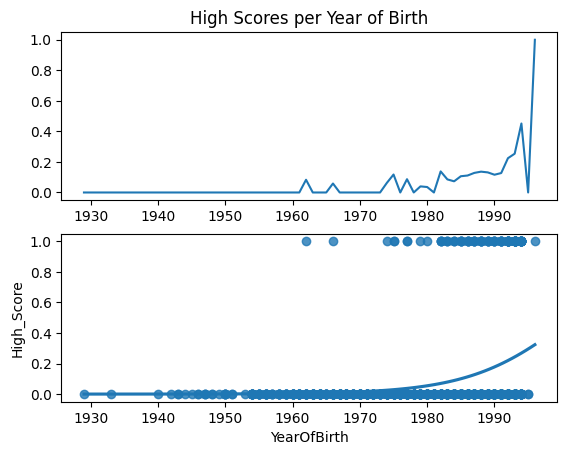

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2)

all_scores_per_year = real_data.groupby('YearOfBirth').size()
high_scores_per_year = real_data[real_data['ScoreText'] == 'High'].groupby('YearOfBirth').size()
rate_of_high_scores_per_year = (high_scores_per_year / all_scores_per_year).fillna(0)

axs[0].plot(rate_of_high_scores_per_year.index, rate_of_high_scores_per_year.values)
axs[0].set_title('High Scores per Year of Birth')

sns.regplot(x='YearOfBirth', y='High_Score', data=real_data, logistic=True, ci=None, ax=axs[1])

plt.show()

In [5]:

# Drop the columns that seem not to influence the prediction
real_data = real_data.drop(['DateOfBirth', 'MonthOfBirth', 'WeekdayOfBirth', 'High_Score'], axis=1)
real_data.dtypes


Sex_Code_Text       object
Ethnic_Code_Text    object
ScaleSet_ID          int64
AssessmentReason    object
Language            object
LegalStatus         object
CustodyStatus       object
MaritalStatus       object
ScoreText           object
YearOfBirth          int64
dtype: object

In [6]:
from sdv.metadata import SingleTableMetadata

metadata = SingleTableMetadata()
metadata.detect_from_dataframe(real_data)
metadata

{
    "columns": {
        "Sex_Code_Text": {
            "sdtype": "categorical"
        },
        "Ethnic_Code_Text": {
            "sdtype": "categorical"
        },
        "ScaleSet_ID": {
            "sdtype": "categorical"
        },
        "AssessmentReason": {
            "sdtype": "categorical"
        },
        "Language": {
            "sdtype": "categorical"
        },
        "LegalStatus": {
            "sdtype": "categorical"
        },
        "CustodyStatus": {
            "sdtype": "categorical"
        },
        "MaritalStatus": {
            "sdtype": "categorical"
        },
        "ScoreText": {
            "sdtype": "categorical"
        },
        "YearOfBirth": {
            "sdtype": "numerical"
        }
    },
    "METADATA_SPEC_VERSION": "SINGLE_TABLE_V1"
}

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split

train_data: pd.DataFrame
test_data: pd.DataFrame
train_data, test_data = train_test_split(real_data, test_size=0.3) 

In [8]:
from sdv.single_table import GaussianCopulaSynthesizer

# Step 1: Create the synthesizer
synthesizer = GaussianCopulaSynthesizer(metadata)

# Step 2: Train the synthesizer
synthesizer.fit(train_data)

# Step 3: Generate synthetic data
synthetic_data = synthesizer.sample(num_rows=len(real_data))
synthetic_data

/Users/gabriel/speml/.venv/lib/python3.9/site-packages/sdv/single_table/base.py:82: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


,Sex_Code_Text,Ethnic_Code_Text,ScaleSet_ID,AssessmentReason,Language,LegalStatus,CustodyStatus,MaritalStatus,ScoreText,YearOfBirth
0,Male,African-American,22,Intake,English,Pretrial,Probation,Married,Low,1973
1,Male,African-American,22,Intake,English,Pretrial,Jail Inmate,Married,High,1967
2,Male,Caucasian,22,Intake,English,Pretrial,Jail Inmate,Single,Medium,1986
3,Female,African-American,22,Intake,English,Pretrial,Jail Inmate,Single,Low,1979
4,Male,Caucasian,22,Intake,English,Post Sentence,Probation,Single,Medium,1994
...,...,...,...,...,...,...,...,...,...,...
995,Male,African-American,22,Intake,English,Pretrial,Probation,Single,Low,1992
996,Male,African-American,22,Intake,English,Post Sentence,Pretrial Defendant,Single,High,1976
997,Male,African-American,22,Intake,English,Pretrial,Pretrial Defendant,Single,Low,1972
998,Male,Caucasian,22,Intake,English,Post Sentence,Probation,Single,Low,1988


In [ ]:
# TODO
# - Compare the distributions of the real and synthetic data

In [29]:
from sdmetrics.single_table import CSTest, ContinuousKLDivergence
from sdv.evaluation.single_table import evaluate_quality

cs_test_results = CSTest.compute(real_data, synthetic_data)

# For continuous columns, you might use ContinuousKLDivergence
kl_divergence_results = ContinuousKLDivergence.compute(real_data, synthetic_data)

# Print results
print("CS Test Results:", cs_test_results)
print("KL Divergence Results:", kl_divergence_results)

quality_report = evaluate_quality(real_data, synthetic_data, metadata)

CS Test Results: 0.9893277423926198
KL Divergence Results: 0.9703553097973316
Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 10/10 [00:00<00:00, 1422.47it/s]|
Column Shapes Score: 98.11%

(2/2) Evaluating Column Pair Trends: |██████████| 45/45 [00:00<00:00, 128.31it/s]|
Column Pair Trends Score: 75.7%

Overall Score (Average): 86.9%



In [15]:
from sklearn.compose import ColumnTransformer
from sklearn.discriminant_analysis import StandardScaler
from sklearn.preprocessing import OneHotEncoder

# Define the ColumnTransformer
column_transformer = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['YearOfBirth']),
        ('cat', OneHotEncoder(), ['Sex_Code_Text', 'Ethnic_Code_Text', 'ScaleSet_ID', 'AssessmentReason',
                                  'Language', 'LegalStatus', 'CustodyStatus', 'MaritalStatus'])
    ],
    remainder='drop'  # This drops the columns not specified in transformers
)
column_transformer.fit(real_data)

print(column_transformer.get_feature_names_out())

def prepare_data(data: pd.DataFrame):
    prediction_var = 'ScoreText'
    X = data.drop(prediction_var, axis=1)
    y = data[prediction_var]

    X_transformed = column_transformer.transform(X)

    return (X_transformed, y)


X_train, y_train = prepare_data(train_data)
X_synthetic, y_synthetic = prepare_data(synthetic_data)
X_test, y_test = prepare_data(test_data)


['num__YearOfBirth' 'cat__Sex_Code_Text_Female' 'cat__Sex_Code_Text_Male'
 'cat__Ethnic_Code_Text_African-Am'
 'cat__Ethnic_Code_Text_African-American' 'cat__Ethnic_Code_Text_Asian'
 'cat__Ethnic_Code_Text_Caucasian' 'cat__Ethnic_Code_Text_Hispanic'
 'cat__Ethnic_Code_Text_Native American' 'cat__Ethnic_Code_Text_Oriental'
 'cat__Ethnic_Code_Text_Other' 'cat__ScaleSet_ID_17' 'cat__ScaleSet_ID_22'
 'cat__AssessmentReason_Intake' 'cat__Language_English'
 'cat__Language_Spanish' 'cat__LegalStatus_Conditional Release'
 'cat__LegalStatus_Other' 'cat__LegalStatus_Post Sentence'
 'cat__LegalStatus_Pretrial' 'cat__LegalStatus_Probation Violator'
 'cat__CustodyStatus_Jail Inmate' 'cat__CustodyStatus_Pretrial Defendant'
 'cat__CustodyStatus_Prison Inmate' 'cat__CustodyStatus_Probation'
 'cat__CustodyStatus_Residential Program' 'cat__MaritalStatus_Divorced'
 'cat__MaritalStatus_Married' 'cat__MaritalStatus_Separated'
 'cat__MaritalStatus_Significant Other' 'cat__MaritalStatus_Single'
 'cat__Marita

In [40]:
from sklearn.ensemble import RandomForestClassifier

clf_train = RandomForestClassifier(random_state=42)
clf_train.fit(X_train, y_train)

real_predictions = clf_train.predict(X_test)

clf_synthetic = RandomForestClassifier(random_state=42)
clf_synthetic.fit(X_synthetic, y_synthetic)

synthetic_predictions = clf_synthetic.predict(X_test)

In [42]:
# Evaluate the classifiers
from sklearn.metrics import classification_report

print("\nClassification report for real model:")
print(classification_report(y_test, real_predictions))

print("\nClassification report for synthetic model:")
print(classification_report(y_test, synthetic_predictions))



Classification report for real model:
              precision    recall  f1-score   support

        High       0.50      0.31      0.38        29
         Low       0.80      0.88      0.84       193
      Medium       0.60      0.55      0.57        78

    accuracy                           0.74       300
   macro avg       0.63      0.58      0.60       300
weighted avg       0.72      0.74      0.73       300


Classification report for synthetic model:
              precision    recall  f1-score   support

        High       0.00      0.00      0.00        29
         Low       0.63      0.88      0.73       193
      Medium       0.17      0.05      0.08        78

    accuracy                           0.58       300
   macro avg       0.27      0.31      0.27       300
weighted avg       0.45      0.58      0.49       300



In [ ]:
# TODO
# Visualziation of outcome
# Compare more synthesizers
# Check privacy risk better

In [22]:
from anonymeter.evaluators import SinglingOutEvaluator

evaluator = SinglingOutEvaluator(ori=train_data, syn=synthetic_data, control=test_data)
evaluator.evaluate()
risk = evaluator.risk()

In [ ]:
from anonymeter.evaluators import InferenceEvaluator

# evaluator = InferenceEvaluator(ori=train_data, syn=synthetic_data, control=test_data)
# evaluator.evaluate()
# risk = evaluator.risk()

In [24]:
print(risk)

PrivacyRisk(value=0.16046717202483568, ci=(0.11745849995977024, 0.2034758440899011))
